In [1]:
import os
import sys
import spotipy
import spotipy.util as util

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, minmax_scale

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import requests
import string

import multiprocessing as mp

import re

from ipywidgets import IntProgress
from IPython.display import display

import nltk

from collections import Counter, defaultdict
from py_genius import Genius
from bs4 import BeautifulSoup

SPOTIPY_REDIRECT_URI='http://localhost:8888/callback'
SPOTIPY_CLIENT_SECRET='c02f97ddd119470d8e24b290722c7490'
SPOTIPY_CLIENT_ID='647ffb8c163b4882be0cafe4bf1352d5'
SCOPE='user-library-read'
USERNAME = '29n1g5zgbzcs413wmovhqdguz'

plt.rcParams['figure.figsize'] = (20, 14)

In [2]:
token = util.prompt_for_user_token(username=USERNAME,
                           scope=SCOPE,
                           client_id=SPOTIPY_CLIENT_ID,
                           client_secret=SPOTIPY_CLIENT_SECRET,
                           redirect_uri=SPOTIPY_REDIRECT_URI)

if not token:
    print("Can't get token for username", username)
    sys.exit(1)

sp = spotipy.Spotify(auth=token)

In [3]:
genius = Genius('D1EklW0p0iQZEo18Ki2SGKBIlBatRKDZvxPcbPYny1Hq2UQo8UJ78abO-DjTXelr')

In [4]:
def get_song_lyrics(song_name):
    search_results = genius.search(song_name)
    try:
        song_url = search_results['response']['hits'][0]['result']['url']
    except:
        return ''
    page = requests.get(song_url)
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics_bytes = html.find('div', class_='lyrics').get_text().encode('ascii', 'ignore')
    lyrics = lyrics_bytes.decode('ascii')
    
    return re.sub(r'\[(.*?)\]', '', lyrics)

In [5]:
get_song_lyrics('blacker the berry')

'\n\n\n\n\nEverything black, I don\'t want black (They want us to bow)\nI want everything black, I ain\'t need black (Down to our knees)\nSome white, some black, I ain\'t mean black (And pray to a God)\nI want everything black (That we don\'t believe)\nEverything black, want all things black\nI don\'t need black, want everything black\nDon\'t need black, our eyes ain\'t black\nI own black, own everything black\n\n\nSix in the morn\', fire in the street\nBurn, baby, burn, that\'s all I wanna see\nAnd sometimes I get off watchin\' you die in vain\nIt\'s such a shame they may call me crazy\nThey may say I suffer from schizophrenia or somethin\'\nBut homie, you made me\nBlack don\'t crack, my nigga\n\n\nI\'m the biggest hypocrite of 2015\nOnce I finish this, witnesses will convey just what I mean\nBeen feeling this way since I was 16, came to my senses\nYou never liked us anyway, fuck your friendship, I meant it\nI\'m African-American, I\'m African\nI\'m black as the moon, heritage of a sm

In [6]:
def get_lyrics_spotify_uri(uri):
    global sp
    while True:
        try:
            track = sp.track(uri)
            track_name = track['name']
            track_artist = track['artists'][0]['name']
            full_name = '{0} - {1}'.format(track_name, track_artist)
            return get_song_lyrics(full_name)
        except:
            token = util.prompt_for_user_token(username=USERNAME,
                               scope=SCOPE,
                               client_id=SPOTIPY_CLIENT_ID,
                               client_secret=SPOTIPY_CLIENT_SECRET,
                               redirect_uri=SPOTIPY_REDIRECT_URI)

            if not token:
                print("Can't get token for username", username)
                sys.exit(1)

            sp = spotipy.Spotify(auth=token)

In [7]:
test = pickle.load(open('datasets/rap_metafeatures', 'rb'))
# test_dict = {
    
# }
# print(test[0])
# print([x])
testtest = test['uri'][4]
print(get_lyrics_spotify_uri(testtest))
x = get_lyrics_spotify_uri(testtest)




Are you alright?
I'm alright, I'm quite alright
And my money's right
8 (yeah)
Countin' them bands
All way to the top 'til they be fallin' over
(yeah, yeah, yeah)
Countin' them bands
On my way to the top 'til we fallin' over


I don't really care if you cry
On the real, you shoulda never lied
Shoulda saw the way she looked me in my eyes
She said: "Baby, I am not afraid to die."
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge


Phantom that's all red, inside all white
Like somethin' you ride a sled down, I just want that head
My Brittany got mad, I'm barely her man now
Everybody got the same swag now
Watch the way that I tear it down
Stackin' my bands all the way to the top
All the way 'til my bands fallin' over
Every time that you leave your spot
Your girlfriend call me like, "Come on over!"
I like the way that she treat me
Gon' leave you, won't leave me, I call it that Casanova
Sh

In [8]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )
        progress.layout.display = 'none'
        box.layout.display = 'none'        

In [9]:
# manager = mp.Manager()
# lyrics_dict = manager.dict()
# output = mp.Queue()

In [10]:
toktok = nltk.tokenize.ToktokTokenizer()

In [11]:
def save_lyrics(genre_matrix, lyrics_d):
    print('begin')
    for uri in log_progress(genre_matrix.uri, every=1):
        if uri not in lyrics_d:
            lyrics = get_lyrics_spotify_uri(uri)
            tokens = set(toktok.tokenize(lyrics.lower()))
            lyrics_d[uri] = tokens
# def save_lyrics(genre_matrix, output):
#     print('begin')
#     lyrics_d = {}
#     for uri in log_progress(genre_matrix.uri, every=1):
#         lyrics = get_lyrics_spotify_uri(uri)
#         tokens = set(toktok.tokenize(lyrics.lower()))
#         lyrics_d[uri] = tokens
#     output.put(lyrics_d)

def get_lyrics_dicts(genre_dict):
    all_classes = list(genre_dict.keys())
    N = 0
    index = defaultdict(dict)
    inverted_index = defaultdict(lambda: defaultdict(set))
        
    for genre_name, genre_matrix in log_progress(genre_dict.items(), every=1):
        N += genre_matrix.shape[0]
        print('Now processing: {}'.format(genre_name))
        for uri in log_progress(genre_matrix.uri, every=1):
            tokens = None
            if uri not in lyrics_dict:
                lyrics = get_lyrics_spotify_uri(uri)
                tokens = set(nltk.tokenize.word_tokenize(lyrics.lower()))
                index[genre_name][uri] = tokens
                lyrics_dict[uri] = tokens
            else:
                index[genre_name][uri] = tokens               
            for token in tokens:
                inverted_index[token][genre_name].add(uri)
    
    return index, inverted_index, N

In [40]:
def mutual_information(t, c, my_index, inverted_index, N):
    # amount of documents that contain tag t, and are in class c
    N_11 =  len(set(inverted_index[t][c])) 

    # amount of documents that contain tag t, but are not in class c
    N_10 =  len(set([
        i for sub in [inverted_index[t][z] for z in [x for x in inverted_index[t].keys() if x != c]]
        for i in sub
    ]))
    
    # amount of documents that do not contain tag t, but are in class c
    N_01 =  len(set([x for x in my_index[c].keys() if t not in my_index[c][x]]))
    
    # amount of documents that do not contain tag t, and are not in class c
    N_00 = N - len(set(my_index[c].keys()) |
                   set([i for sub in [
                       inverted_index[t][s] for s in inverted_index[t].keys() if s != c
                   ] for i in sub]))
    
    # Get all the formula's written down for easier returning
    m_1 = (N_11 / N) * np.log2((N * N_11 / ((N_11 + N_10) * (N_11 + N_01))))\
        if N_11 != 0 and N_11 + N_10 != 0 and N_11 + N_01 != 0 else 0
                
    m_2 = (N_01 / N) * np.log2((N * N_01 / ((N_01 + N_00) * (N_11 + N_01))))\
        if N_01 != 0 and N_01 + N_00 != 0 and N_11 + N_01 != 0 else 0
        
    m_3 = (N_10 / N) * np.log2((N * N_10 / ((N_11 + N_10) * (N_10 + N_00))))\
        if N_10 != 0 and N_11 + N_10 != 0 and N_10 + N_00 != 0 else 0
        
    m_4 = (N_00 / N) * np.log2((N * N_00 / ((N_01 + N_00) * (N_10 + N_00))))\
        if N_00 != 0 and N_01 + N_00 != 0 and N_10 + N_00 != 0 else 0

    return -(m_1 + m_2 + m_3 + m_4)

In [13]:
genre_dict = {
    'rap': pickle.load(open('datasets/rap_metafeatures', 'rb')),
    'techno': pickle.load(open('datasets/techno_metafeatures', 'rb')),
    'soul': pickle.load(open('datasets/soul_metafeatures', 'rb')),
    'grunge': pickle.load(open('datasets/grunge_metafeatures', 'rb')),
    'metal': pickle.load(open('datasets/metal_metafeatures', 'rb')),
    'meditation': pickle.load(open('datasets/meditation_metafeatures', 'rb')),
    'k-pop': pickle.load(open('datasets/k-pop_metafeatures', 'rb')),
    'hardcore': pickle.load(open('datasets/hardcore_metafeatures', 'rb')),
    'rock': pickle.load(open('datasets/rock_metafeatures', 'rb')),
    'punk': pickle.load(open('datasets/punk_metafeatures', 'rb')),
    'jazz': pickle.load(open('datasets/jazz_metafeatures', 'rb')),
    'funk': pickle.load(open('datasets/funk_metafeatures', 'rb')),
    'vaporwave': pickle.load(open('datasets/vaporwave_metafeatures', 'rb')),
    'classical': pickle.load(open('datasets/classical_metafeatures', 'rb')),
    'hiphop': pickle.load(open('datasets/hiphop_metafeatures', 'rb')),
    'house': pickle.load(open('datasets/house_metafeatures', 'rb')),
}

In [14]:
# index, inverted_index, N = get_lyrics_dicts(genre_dict)

# Multiprocessing

In [15]:
# output = {}
# processes = [mp.Process(target=save_lyrics, args=(genre_matrix[:1000],output)) for genre_matrix in genre_dict.values()]

# for p in processes:
#     p.start()
    
# for p in processes:
#     p.join()
    
# # results = [output.get() for p in processes]

In [16]:
# results

In [17]:
# pickle.dump(results, open('/home/nima/projects/results', 'wb'))

In [18]:
# print(list(lyrics_dict.values())[:3])

In [19]:
# pickle.dump(lyrics_dict, open('/home/nima/projects/lyrics_dict', 'wb'))

In [20]:
# len(lyrics_dict)
# print(genre_dict['soul'].uri[0])
# print(lyrics_dict['spotify:track:3b0EOvScbZUc0qJx0E1L2z'])

In [21]:
lyrics = pd.read_csv('datasets/lyrics.csv')

In [22]:
def get_lyrics_dicts(genre_dict):
    all_classes = list(genre_dict.keys())
    N = 0
    index = defaultdict(dict)
    inverted_index = defaultdict(lambda: defaultdict(set))
        
    for genre_name, lyric_list in genre_dict.items():
        N += len(lyric_list)
        for song, lyric in lyric_list:
            try:
                tokens = set(toktok.tokenize(lyric.lower()))
            except:
                tokens = set()
            index[genre_name][song] = tokens
            for token in tokens:
                inverted_index[token][genre_name].add(song)
    
    return index, inverted_index, N

In [23]:
# genre_dict = defaultdict(list)

# for genre, song, lyric in zip(lyrics.genre, lyrics.song, lyrics.lyrics):
#     genre_dict[genre].append((song, lyric))

In [24]:
# # print(lyrics['song'], lyrics['lyrics'])   
# index, inverted_index, N = get_lyrics_dicts(genre_dict)

In [25]:
# print(inverted_index.keys())

In [26]:
# pickle.dump(list(inverted_index.items()), open('datasets/inverted_index_kaggle', 'wb'))
# pickle.dump(list(index.items()), open('datasets/index_kaggle', 'wb'))

In [27]:
index = pickle.load(open('datasets/index_kaggle', 'rb'))
inverted_index = pickle.load(open('datasets/inverted_index_kaggle', 'rb'))

In [31]:
index = dict(index)
inverted_index = dict(inverted_index)

In [48]:
N = len(lyrics)

In [49]:
# import multiprocessing as mp

# def test(a, m, di):
#     a = np.array(a)
#     aa = a ** 2 / 3 * 4
#     b = np.vstack((aa, aa + 3, aa / 2))
#     for i in a:
#         di[i] = m.dict()
#         for index, j in enumerate(b.flatten()):
#             di[i][j] = j
# #             print({j : b.flatten()[index]})
# #             dd = dict()
# #             dd.update({j : b.flatten()[index]})
# #             print(dd)
# #             print(dict().update({j : b.flatten()[index]}))
# #             di[i].update(dd)
            

# m = mp.Manager()
# d = m.dict()

# processes = [mp.Process(target=test, args=(l, m, d)) for l in [[1,2,3],[4,5,7],[8,9,6]]]

# for p in processes:
#     p.start()
    
# for p in processes:
#     p.join()

In [50]:
# for p in processes:
#     p.join()

In [51]:
import multiprocessing as mp

def get_mis(genre, d, m, index, inverted_index, N):
    d[genre] = m.dict()
    for term in list(inverted_index.keys()):
        d[genre][term] = mutual_information(term, genre, index, inverted_index, N)
        
m = mp.Manager()
d = m.dict()        

processes = [mp.Process(target=get_mis, args=(genre, d, m, index, inverted_index, N))
             for genre in index.keys()]

for p in processes:
    p.start()
    
for p in processes:
    p.join()

In [53]:
# pickle.dump(d, open('/home/nima/projects/mi_d', 'wb'))
pickle.dump([list(d[genre].items()) for genre in index.keys()], open('/home/nima/projects/mi_sub_list', 'wb'))

In [133]:
sorted_dict = {}
for genre in d.keys():
    genre_l = list(d[genre].items())
    words, vals = zip(*genre_l)
    vals_a = np.array(vals)
    vals_a *= -1
    sorted_l = sorted(list(zip(words, vals_a)), key=lambda x: x[1], reverse=True)
    sorted_dict[genre] = sorted_l

In [135]:
top10_dict = {}
for genre in d.keys():
    top10_dict[genre] = sorted_dict[genre][:10]

In [136]:
for genre in d.keys():
    print(genre)
    print(sorted_dict[genre][:10])

Pop
[('tu', 0.0030999470602339589), ('un', 0.0027105633378552681), ('±', 0.0025492149589648994), ('te', 0.0024948899909813093), ('que', 0.0022842137294998713), ('©', 0.002083815672339106), ('mi', 0.0019857220409834099), ('ti', 0.0019852554777568384), ('amor', 0.0018898880246781924), ('en', 0.0018143359167454307)]
Hip-Hop
[('nigga', 0.069790808017003839), ('shit', 0.063827188528093076), ('niggas', 0.052847359089543647), ('fuck', 0.049576799808478046), ('bitch', 0.047288522714484006), ('ain', 0.039098514999895556), ('ass', 0.03734723150228187), ('em', 0.037326280154861072), ('yo', 0.035448503002039763), ('bitches', 0.029678707885996941)]
Not Available
[('que', 0.0043865613570750498), ('de', 0.0037232427869418544), ('se', 0.0031600526091001236), ('en', 0.0025726921163395471), ('amor', 0.0024343440024664881), ('te', 0.0022293428815835774), ('un', 0.0018922401449550695), ('por', 0.0018490222954847244), ('le', 0.0018234400748699288), ('tu', 0.0018155394966274771)]
Other
[('ä', 0.000379012471

In [137]:
firstns = {genre: sorted_dict[genre][:50] for genre in d.keys()}
word_props = {}
for genre in firstns:
    l = firstns[genre]
    names, vals = list(zip(*l))
    vals_a = np.array(vals)
    vals_a = vals_a / vals_a.min()
    word_props[genre] = list(zip(names, vals_a))

bogus_d = {}
for genre in word_props:
    bogus = []
    for word, prop in word_props[genre]:
        bogus.extend([word] * int(1000 * prop))
    bogus_d[genre] = bogus

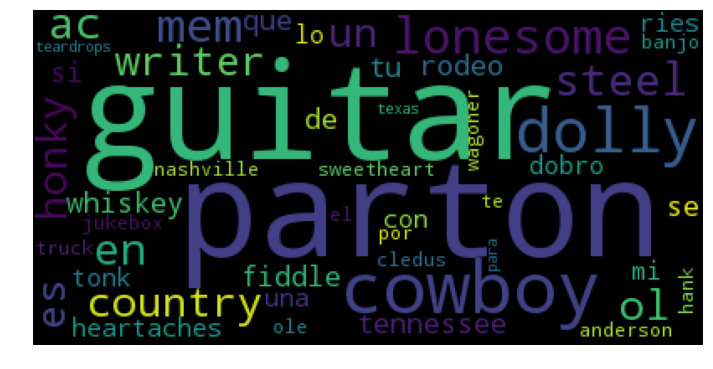

In [142]:
#!/usr/bin/env python
"""
Colored by Group Example
========================
Generating a word cloud that assigns colors to words based on
a predefined mapping from colors to words
"""

from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.
       Uses wordcloud.get_single_color_func
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


text = ' '.join(bogus_d['Country'])

# Since the text is small collocations are turned off and text is lower-cased
wc = WordCloud(collocations=False).generate(text.lower())



# Plot
plt.figure(figsize=(12.0, 8.0))
plt.imshow(wc, interpolation="hanning")
plt.axis("off")
plt.show()
